In [ ]:
from google.colab import drive

drive.mount('/content/drive')

**Import dataset**

In [ ]:
import pandas as pd
df=pd.read_csv('/content/LDA_data.csv', encoding='cp1252' )


In [ ]:
df


,Review
0,I found the process to be incredibly efficient...
1,"The process was a bit cumbersome, and I strugg..."
2,I was impressed by how quickly the process was...
3,There were some technical glitches encountered...
4,The support team was fantastic! They were resp...
...,...
405,We encountered issues with job postings not re...
406,Our experience was neutral; the platform's fea...
407,The trial period allowed us to explore diverse...
408,"The trial's duration provided flexibility, acc..."


 **Libraries import**

In [ ]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
%matplotlib inline

# package to clean text
import re

# I am going to use Genisis package for the modelling.
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# nltk
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# package to print
from pprint import pprint

# settings to display
pd.set_option("display.max_columns", None)
pd.options.display.max_colwidth = 50


import warnings;
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

!pip install pyLDAvis
!pip install gensim

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from IPython.display import IFrame





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

**Exploratory analysis**

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  410 non-null    object
dtypes: object(1)
memory usage: 3.3+ KB
None


In [ ]:
df.columns = ['review']

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  410 non-null    object
dtypes: object(1)
memory usage: 3.3+ KB
None


In [ ]:
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

display(df.head())

,review
0,I found the process to be incredibly efficient and user-friendly. The step-by-step instructions ...
1,"The process was a bit cumbersome, and I struggled to find the necessary information. It would be..."
2,I was impressed by how quickly the process was completed. The automated features streamlined eve...
3,"There were some technical glitches encountered during the process, causing delays. Enhancing sys..."
4,The support team was fantastic! They were responsive and helpful whenever I encountered an issue...


**Data preprossesing**

In [ ]:
# Data cleaning considering for the corpus just nouns, adjectives, verbs and adverbs

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df['data'] = list(sent_to_words(df.review))

# After tokenization remove stoword and apply lemmatization
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ']):

    # remove stop words
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []

    # Lemmatization
    nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

df['data_ready'] = process_words(df.data)

In [ ]:
document_token_counts = [len(tokens) for tokens in df.data_ready]

# Total token count for the dataset
total_tokens = sum(document_token_counts)

print(f'Total Tokens in Dataset: {total_tokens}')

Total Tokens in Dataset: 4484


In [ ]:
# IMPLEMENTED VERSION - Data cleaning considering for the corpus just nouns, adjectives

#First tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df['data'] = list(sent_to_words(df.review))

# After tokenization remove stoword and apply lemmatization
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', "ADV"  ]):

    # remove stop words
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []

    # Lemmatization
    nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

df['data_test'] = process_words(df.data)

In [ ]:
df

,review,data,data_ready,data_test
0,I found the process to be incredibly efficient and user-friendly. The step-by-step instructions ...,"[found, the, process, to, be, incredibly, efficient, and, user, friendly, the, step, by, step, i...","[process, efficient, user, friendly, step, step, instruction, easy, navigate, confusion]","[find, process, incredibly, efficient, user, friendly, step, step, instruction, make, easy, navi..."
1,"The process was a bit cumbersome, and I struggled to find the necessary information. It would be...","[the, process, was, bit, cumbersome, and, struggled, to, find, the, necessary, information, it, ...","[process, bit, cumbersome, necessary, information, clear, guideline, intuitive, layout, user, ex...","[process, bit, cumbersome, struggle, find, necessary, information, helpful, clear, guideline, in..."
2,I was impressed by how quickly the process was completed. The automated features streamlined eve...,"[was, impressed, by, how, quickly, the, process, was, completed, the, automated, features, strea...","[process, feature, lot, time]","[impress, quickly, process, complete, automate, feature, streamline, save, lot, time]"
3,"There were some technical glitches encountered during the process, causing delays. Enhancing sys...","[there, were, some, technical, glitches, encountered, during, the, process, causing, delays, enh...","[technical, glitch, process, delay, system, stability, overall, experience]","[technical, glitch, encounter, process, cause, delay, enhance, system, stability, greatly, impro..."
4,The support team was fantastic! They were responsive and helpful whenever I encountered an issue...,"[the, support, team, was, fantastic, they, were, responsive, and, helpful, whenever, encountered...","[support, team, fantastic, responsive, helpful, issue, process, stressful]","[support, team, fantastic, responsive, helpful, encounter, issue, process, make, much, less, str..."
5,"The process lacked transparency in certain stages, leaving me unsure about the next steps. Addin...","[the, process, lacked, transparency, in, certain, stages, leaving, me, unsure, about, the, next,...","[process, transparency, certain, stage, unsure, next, step, status, update, tracker]","[process, lack, transparency, certain, stage, leave, unsure, next, step, add, status, update, pr..."
6,I appreciated the thoroughness of the process. It ensured that all necessary details were covere...,"[appreciated, the, thoroughness, of, the, process, it, ensured, that, all, necessary, details, w...","[thoroughness, process, necessary, detail, successful, outcome]","[appreciate, thoroughness, process, ensure, necessary, detail, cover, lead, successful, outcome]"
7,The mobile accessibility of the process needs improvement. It was challenging to complete certai...,"[the, mobile, accessibility, of, the, process, needs, improvement, it, was, challenging, to, com...","[mobile, accessibility, process, improvement, complete, certain, step, small, screen, overall, e...","[mobile, accessibility, process, need, improvement, challenge, complete, certain, step, small, s..."
8,"The simplicity of the process was a standout feature. It was straightforward and easy to follow,...","[the, simplicity, of, the, process, was, standout, feature, it, was, straightforward, and, easy,...","[simplicity, process, standout, straightforward, easy, follow, accessible, user, level]","[simplicity, process, standout, feature, straightforward, easy, follow, make, accessible, user, ..."
9,The process felt personalized and tailored to my needs. It was evident that considerable thought...,"[the, process, felt, personalized, and, tailored, to, my, needs, it, was, evident, that, conside...","[process, need, evident, considerable, thought, user, journey]","[process, feel, personalize, tailor, need, evident, considerable, thought, go, understand, user,..."


In [ ]:
df['data_ready']

0      ['find', 'process', 'incredibly', 'efficient', 'user', 'friendly', 'step', 'step', 'instruction'...
1      ['process', 'bit', 'cumbersome', 'struggle', 'find', 'necessary', 'information', 'helpful', 'cle...
2      ['impress', 'quickly', 'process', 'complete', 'automate', 'feature', 'streamline', 'save', 'lot'...
3      ['technical', 'glitch', 'encounter', 'process', 'cause', 'delay', 'enhance', 'system', 'stabilit...
4      ['support', 'team', 'fantastic', 'responsive', 'helpful', 'encounter', 'issue', 'process', 'make...
5      ['process', 'lack', 'transparency', 'certain', 'stage', 'leave', 'unsure', 'next', 'step', 'add'...
6      ['appreciate', 'thoroughness', 'process', 'ensure', 'necessary', 'detail', 'cover', 'lead', 'suc...
7      ['mobile', 'accessibility', 'process', 'need', 'improvement', 'challenge', 'complete', 'certain'...
8      ['simplicity', 'process', 'standout', 'feature', 'straightforward', 'easy', 'follow', 'make', 'a...
9      ['process', 'feel', 'personali

**LDA model implementation**

In [ ]:
#Implementation of LDA model with genism

#  Dictionary
id2word = corpora.Dictionary(df.data_test)

#  Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df.data_test]

# Build LDA model
lda_model_test = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 5,
                                           random_state=10,
                                           chunksize=9,
                                           passes=15,
                                           iterations=300,
                                           per_word_topics=True)

# Look at the topics and key words
pprint(lda_model_test.print_topics())

[(0,
  '0.079*"job" + 0.042*"posting" + 0.039*"pricing" + 0.028*"follow" + '
  '0.028*"structure" + 0.025*"audience" + 0.022*"friendly" + 0.022*"reach" + '
  '0.018*"intended" + 0.018*"various"'),
 (1,
  '0.074*"experience" + 0.058*"trial" + 0.052*"support" + 0.045*"team" + '
  '0.032*"bit" + 0.029*"time" + 0.026*"specific" + 0.025*"issue" + '
  '0.024*"enhance" + 0.024*"lack"'),
 (2,
  '0.104*"trial" + 0.066*"provide" + 0.060*"platform" + 0.052*"period" + '
  '0.021*"cost" + 0.021*"well" + 0.016*"positive" + 0.016*"additional" + '
  '0.015*"guidance" + 0.014*"journey"'),
 (3,
  '0.073*"platform" + 0.042*"customer" + 0.041*"hire" + 0.035*"offer" + '
  '0.032*"get" + 0.029*"post" + 0.026*"functionality" + 0.022*"level" + '
  '0.022*"satisfactory" + 0.018*"right"'),
 (4,
  '0.061*"platform" + 0.057*"feature" + 0.055*"candidate" + 0.042*"allow" + '
  '0.041*"interface" + 0.035*"diverse" + 0.035*"pool" + 0.034*"talent" + '
  '0.024*"find" + 0.021*"flexibility"')]


In [ ]:
# Get the top-N words for each topic in the LDA model
topics_words = lda_model_test.show_topics(num_topics=5, num_words=10, formatted=False)

# Print and display the top-N words for each topic
for topic, words in topics_words:
    top_words = [word for word, _ in words]
    print(f"Topic {topic}: {', '.join(top_words)}")

Topic 0: job, posting, pricing, follow, structure, audience, friendly, reach, intended, various
Topic 1: experience, trial, support, team, bit, time, specific, issue, enhance, lack
Topic 2: trial, provide, platform, period, cost, well, positive, additional, guidance, journey
Topic 3: platform, customer, hire, offer, get, post, functionality, level, satisfactory, right
Topic 4: platform, feature, candidate, allow, interface, diverse, pool, talent, find, flexibility


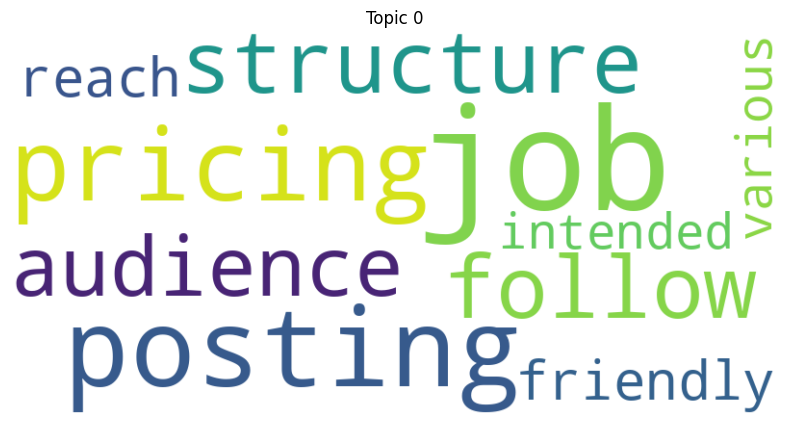

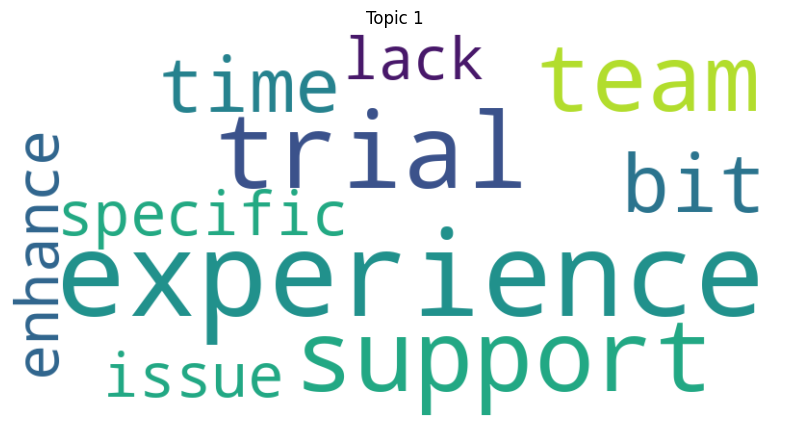

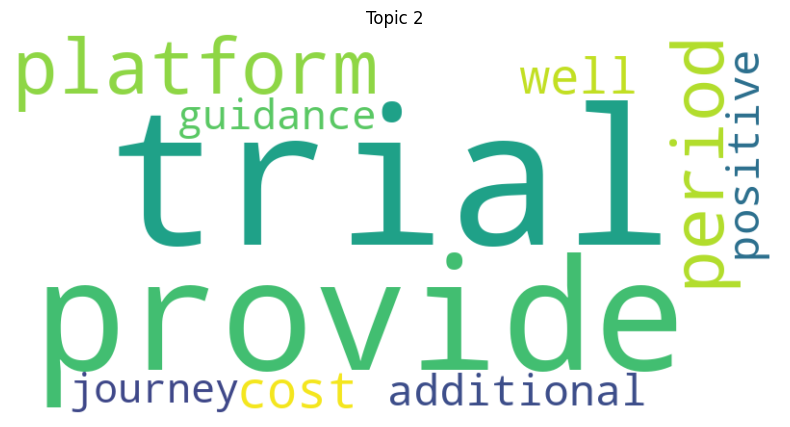

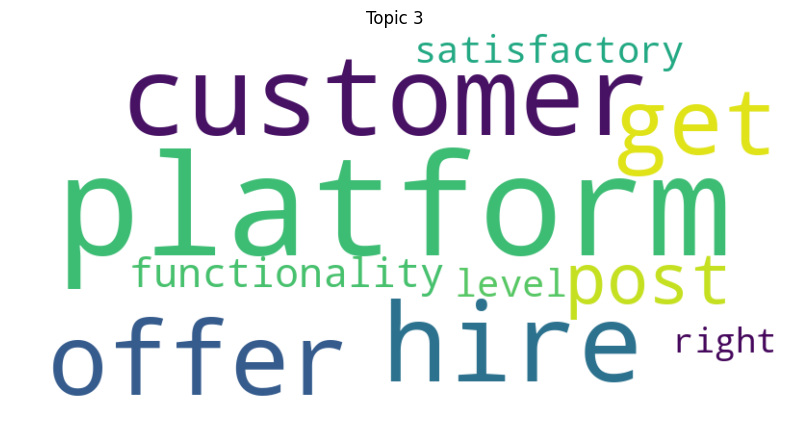

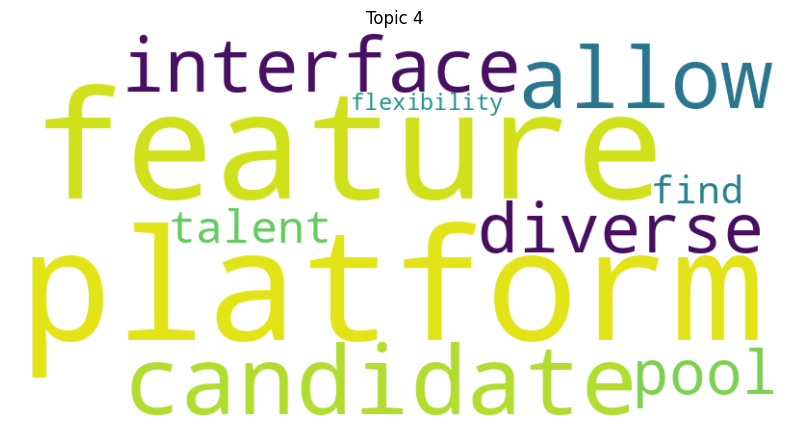

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Get the top words for each topic in the LDA model
topics_words = lda_model_test.show_topics(formatted=False)

# Generate word clouds for each topic
for topic, words in topics_words:
    word_freq = {word: freq for word, freq in words}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud for each topic
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic}")
    plt.axis('off')
    plt.show()

In [ ]:

# Get the topic-word distributions
topics = lda_model_test.show_topics(num_topics=5, num_words=10, formatted=False)

# Display the word probabilities for each topic
for topic, word_probs in topics:
    print(f"Topic {topic}:")
    for word, prob in word_probs:
        print(f"  {word}: {prob:.4f}")
    print()


Topic 0:
  job: 0.0792
  posting: 0.0423
  pricing: 0.0392
  follow: 0.0284
  structure: 0.0279
  audience: 0.0252
  friendly: 0.0221
  reach: 0.0219
  intended: 0.0183
  various: 0.0179

Topic 1:
  experience: 0.0744
  trial: 0.0580
  support: 0.0525
  team: 0.0449
  bit: 0.0316
  time: 0.0286
  specific: 0.0256
  issue: 0.0255
  enhance: 0.0243
  lack: 0.0238

Topic 2:
  trial: 0.1036
  provide: 0.0659
  platform: 0.0601
  period: 0.0518
  cost: 0.0214
  well: 0.0206
  positive: 0.0164
  additional: 0.0160
  guidance: 0.0145
  journey: 0.0137

Topic 3:
  platform: 0.0731
  customer: 0.0421
  hire: 0.0407
  offer: 0.0347
  get: 0.0318
  post: 0.0293
  functionality: 0.0256
  level: 0.0219
  satisfactory: 0.0218
  right: 0.0184

Topic 4:
  platform: 0.0610
  feature: 0.0569
  candidate: 0.0552
  allow: 0.0425
  interface: 0.0406
  diverse: 0.0353
  pool: 0.0349
  talent: 0.0338
  find: 0.0242
  flexibility: 0.0207



In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df.data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,5), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_test, corpus=corpus, texts=df.data_test)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()


In [ ]:
df_dominant_topic.head()

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,data_test
0,0,0,0.488,"job, posting, pricing, follow, structure, audience, friendly, reach, intended, various","[find, process, incredibly, efficient, user, friendly, step, step, instruction, make, easy, navi..."
1,1,1,0.720,"experience, trial, support, team, bit, time, specific, issue, enhance, lack","[process, bit, cumbersome, struggle, find, necessary, information, helpful, clear, guideline, in..."
2,2,1,0.426,"experience, trial, support, team, bit, time, specific, issue, enhance, lack","[impress, quickly, process, complete, automate, feature, streamline, save, lot, time]"
3,3,1,0.798,"experience, trial, support, team, bit, time, specific, issue, enhance, lack","[technical, glitch, encounter, process, cause, delay, enhance, system, stability, greatly, impro..."
4,4,1,0.938,"experience, trial, support, team, bit, time, specific, issue, enhance, lack","[support, team, fantastic, responsive, helpful, encounter, issue, process, make, much, less, str..."


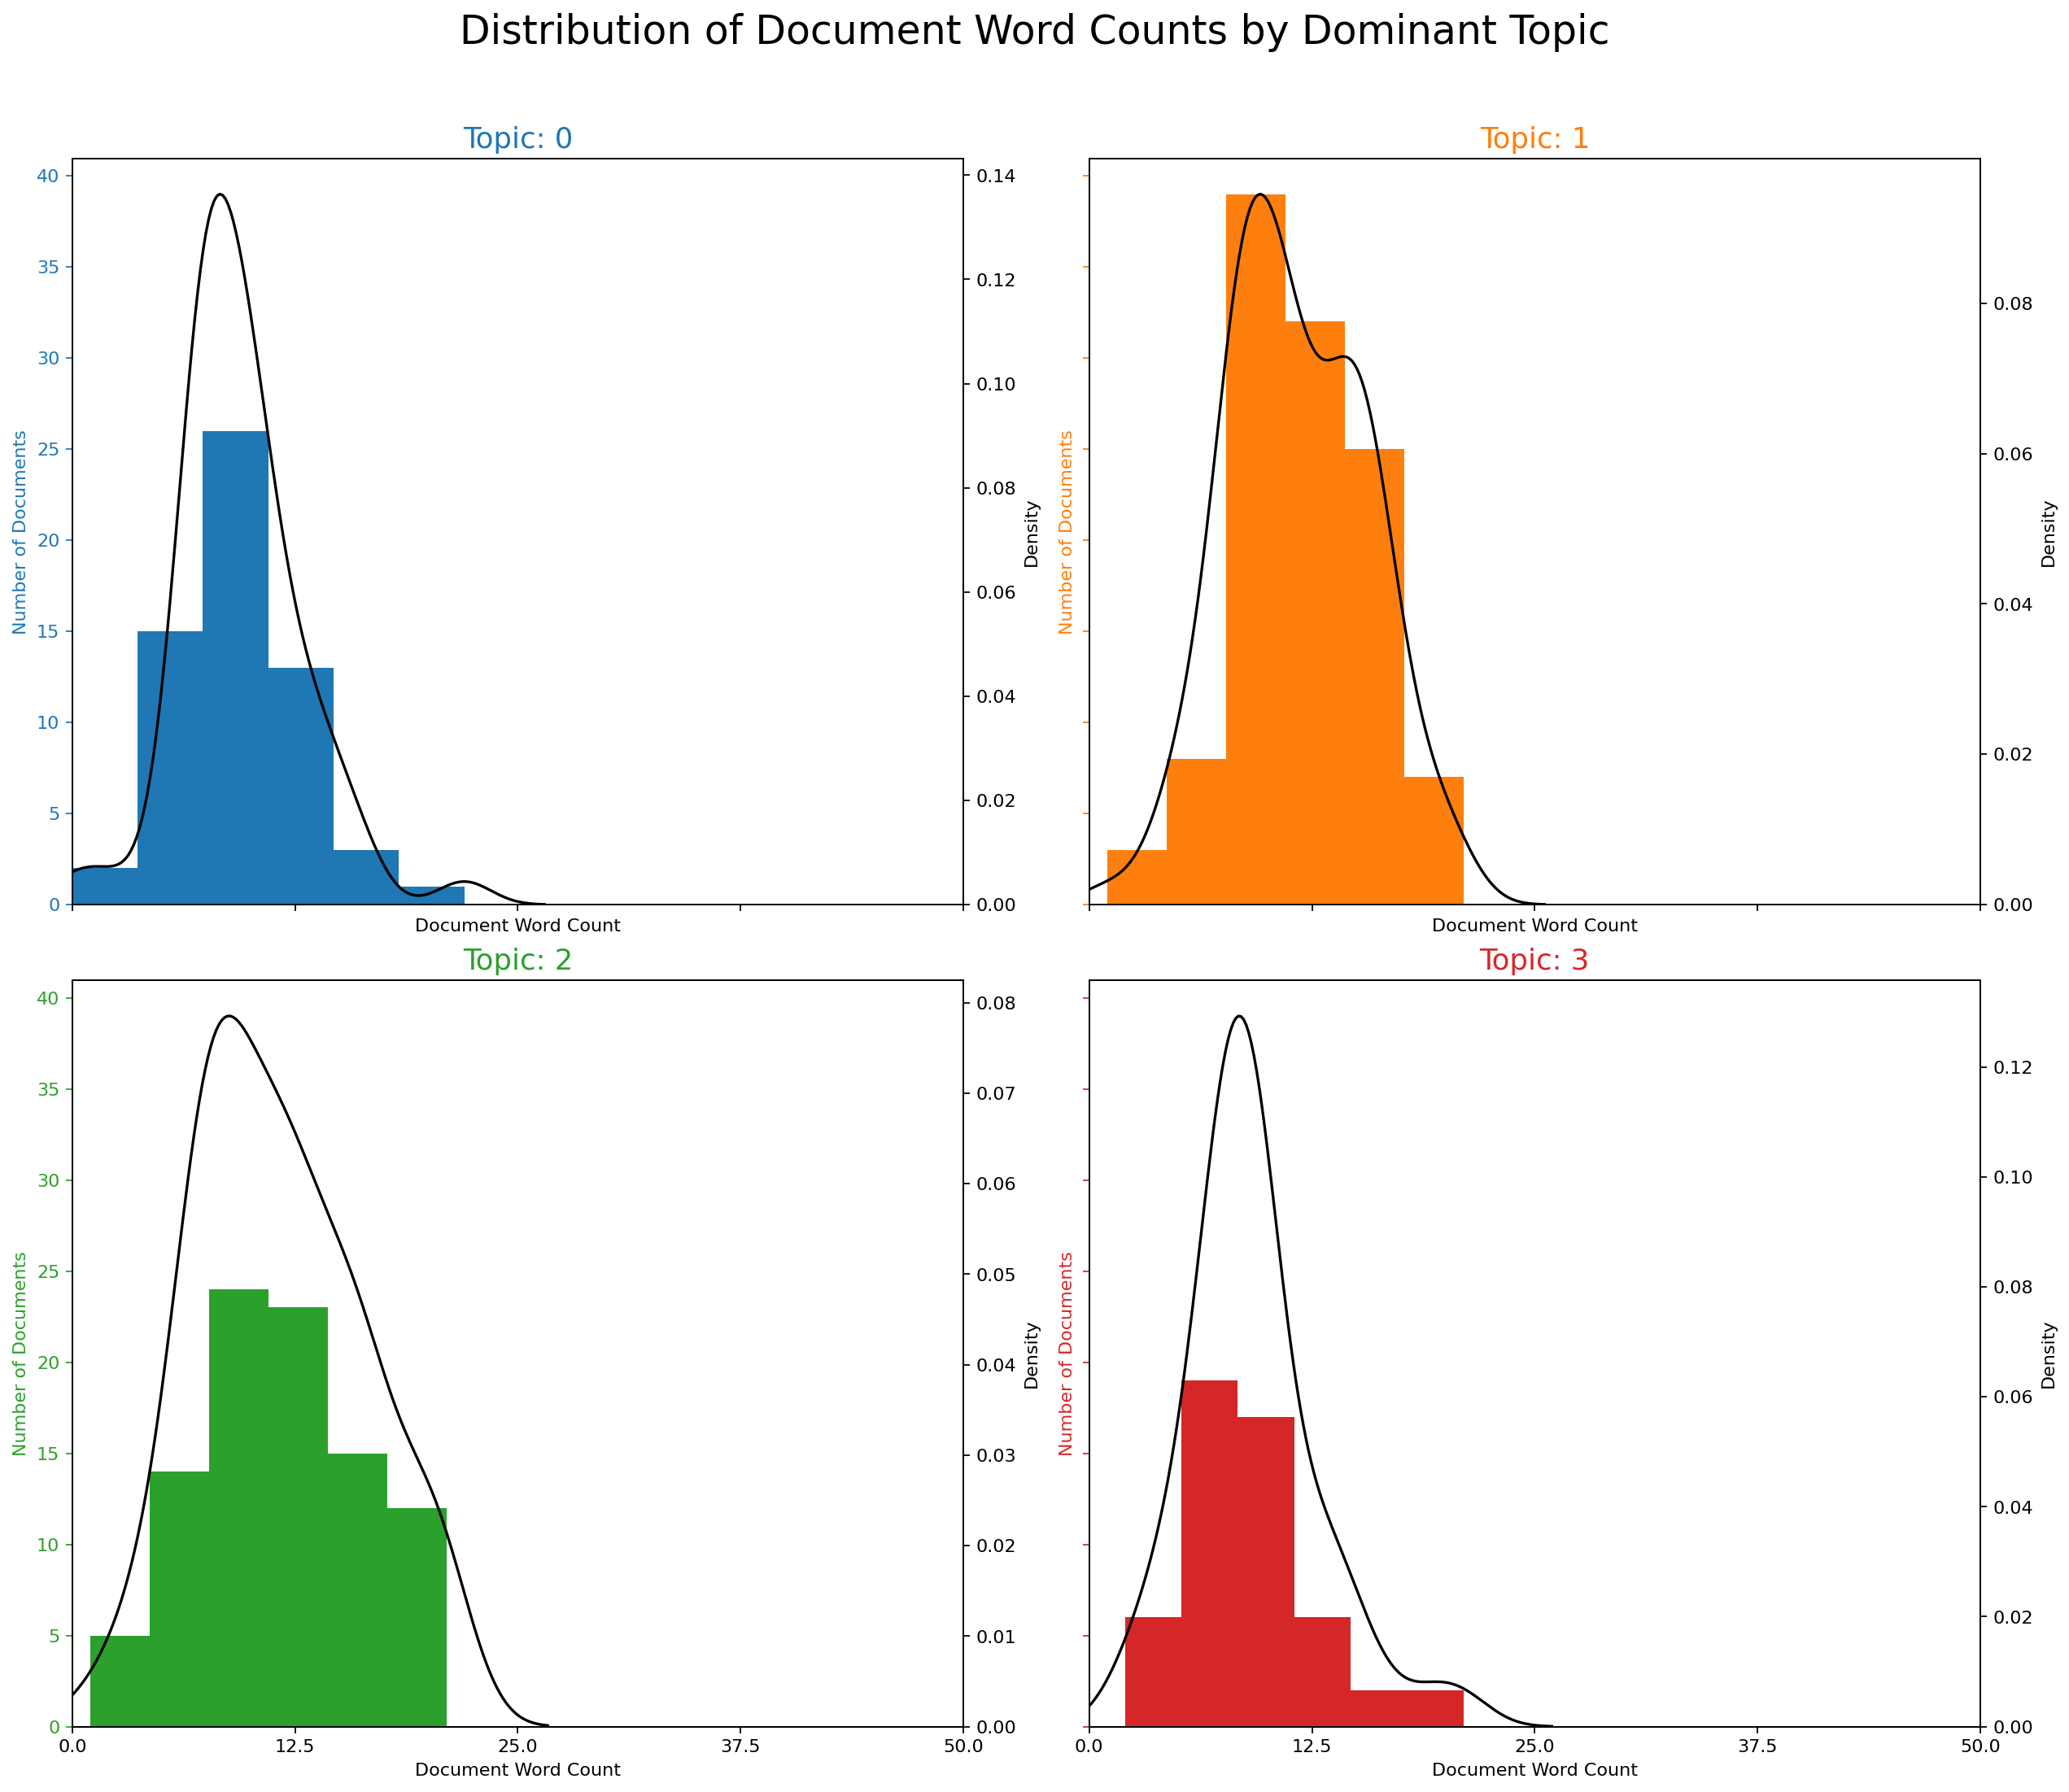

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.data_test]
    ax.hist(doc_lens, bins = 6, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0,40), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,50,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_test[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 394 samples in 0.001s...
[t-SNE] Computed neighbors for 394 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 394 / 394
[t-SNE] Mean sigma: 0.155821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.606415
[t-SNE] KL divergence after 1000 iterations: 0.469663


In [ ]:
!pip install pandas==1.5.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 28.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
vis_data = gensimvis.prepare(lda_model_test, corpus, id2word)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df.data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.793001593705528

Coherence Score:  0.44946605375752147
